### Disusun Oleh:
 1. Fiqri Aldiansyah (122140152)
 2. Rustian Afencius Marbun (122140155)
 3. A Kevin Sergian (122140125)

# Analisis Anomali Dataset Stok dan Pembelian

**Tujuan:** Notebook ini bertujuan untuk melakukan analisis data lengkap pada dataset Stok dan Pembelian. Proses ini mencakup pembersihan data, analisis eksploratif (EDA), deteksi anomali menggunakan metode statistik dan machine learning, serta analisis gabungan untuk memeriksa konsistensi antar kedua dataset.

**Metodologi:**
1.  **Setup Awal:** Inisialisasi lingkungan dan pemuatan library.
2.  **Bagian 1: Analisis Dataset Stok:** Pemuatan, pembersihan, dan deteksi anomali internal.
3.  **Bagian 2: Analisis Dataset Pembelian:** Pemuatan, pembersihan, deteksi anomali internal, termasuk identifikasi transaksi bernilai besar.
4.  **Bagian 3: Analisis Gabungan:** Deteksi anomali lintas dataset dan pembahasan strategi membedakan anomali dari transaksi sah.
5.  **Kesimpulan & Rekomendasi:** Rangkuman temuan dan saran perbaikan.

## Setup Lingkungan & Inisialisasi

Sel pertama ini bertujuan untuk mempersiapkan lingkungan kerja. Langkah-langkahnya meliputi:
1.  **Menghubungkan (Mount) Google Drive:** Agar notebook dapat mengakses file dataset yang tersimpan di Google Drive.
2.  **Mengimpor Library:** Memuat semua library Python yang akan digunakan untuk manipulasi data (`pandas`, `numpy`), visualisasi (`matplotlib`, `seaborn`), dan deteksi anomali (`sklearn`).

In [ ]:
# Menghubungkan ke Google Drive untuk akses dataset
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive berhasil terhubung.")

# Mengimpor semua library Python yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest # Contoh untuk ML-based, meskipun akan fokus Rule-Based dan Statistik

# Mengatur tampilan plot agar lebih profesional
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Ukuran default plot
plt.rcParams['figure.dpi'] = 100 # Resolusi plot

print("Semua library yang dibutuhkan telah diimpor.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil terhubung.
Semua library yang dibutuhkan telah diimpor.


### Bagian 1: Analisis Internal Dataset Stok

Bagian ini berfokus pada pemuatan dataset `Stok`, melakukan pembersihan data untuk memastikan kualitasnya, dan mengidentifikasi anomali atau inkonsistensi yang ada di dalamnya secara internal.

#### 1.1 Pemuatan dan Pembersihan Data Stok

Pada bagian ini, kita akan fokus pada dataset `Stok`. Mengingat format filenya adalah *fixed-width* yang tidak standar, kita menggunakan metode `pd.read_fwf` dengan spesifikasi posisi kolom (`colspecs`) manual. Setelah berhasil dimuat, data akan melalui proses pembersihan awal yang meliputi:
* Menghapus spasi ekstra pada data teks.
* Mengonversi kolom `QTY_STOK` dari format string (dengan desimal koma) menjadi format numerik.
* Menghapus baris yang tidak valid (data `KODE` atau `QTY_STOK` kosong) dan baris duplikat.

In [ ]:
# Path menuju file Stok Anda di Google Drive
file_path_stok = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Stok.csv'

try:
    # Spesifikasi kolom untuk file fixed-width
    col_specs = [(0, 11), (11, 50), (50, 62), (62, 73), (73, 80)]
    col_names = ['KODE', 'NAMA_PRODUK', 'LOKASI', 'QTY_STOK', 'UNIT']
    df_stok = pd.read_fwf(file_path_stok, colspecs=col_specs, names=col_names, skiprows=1)

    # Pembersihan Teks: Menghapus spasi di awal/akhir string
    for col in df_stok.select_dtypes(include=['object']).columns:
        df_stok[col] = df_stok[col].str.strip()

    # Konversi Tipe Data: QTY_STOK dari string ke numerik
    df_stok['QTY_STOK'] = df_stok['QTY_STOK'].astype(str).str.replace(',', '.', regex=False)
    df_stok['QTY_STOK'] = pd.to_numeric(df_stok['QTY_STOK'], errors='coerce')

    # Penanganan Nilai Hilang dan Duplikat
    df_stok.dropna(subset=['KODE', 'QTY_STOK'], inplace=True) # Hapus baris jika KODE atau QTY_STOK kosong
    df_stok.drop_duplicates(inplace=True) # Hapus baris duplikat

    print("Dataset STOK berhasil dimuat dan dibersihkan.")
    print("\n--- 5 Baris Pertama Data Stok Setelah Pembersihan ---")
    display(df_stok.head())
    print("\n--- Informasi Data Stok ---")
    df_stok.info()

except Exception as e:
    print(f"Error saat memproses data Stok: {e}")

Dataset STOK berhasil dimuat dan dibersihkan.

--- 5 Baris Pertama Data Stok Setelah Pembersihan ---


,KODE,NAMA_PRODUK,LOKASI,QTY_STOK,UNIT
2,""" A000001",ANATON TAB,ETL1,12.0,00 STR
4,""" A00001",ACTIVED HIJAU,ETL3A,2.0,00 BTL
6,""" A000012",APIALYS SYR 100 ML,ETL3A,2.0,00 BTL
8,""" A000014",ALKOHOL 1000 ML,ETL3B,7.0,00 BTL
10,""" A000016",ALLOPURINOL 300,RAK2,40.0,00 STR



--- Informasi Data Stok ---
<class 'pandas.core.frame.DataFrame'>
Index: 1516 entries, 2 to 3036
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   KODE         1516 non-null   object 
 1   NAMA_PRODUK  1516 non-null   object 
 2   LOKASI       1514 non-null   object 
 3   QTY_STOK     1516 non-null   float64
 4   UNIT         1516 non-null   object 
dtypes: float64(1), object(4)
memory usage: 71.1+ KB


### 1.2. Analisis Eksploratif (EDA) & Deteksi Anomali Internal Stok

Setelah data Stok bersih, kita melakukan analisis untuk menemukan anomali internal.
* **Visualisasi Box Plot:** Untuk melihat distribusi data `QTY_STOK` dan mengidentifikasi adanya outlier (nilai ekstrem) secara visual.
* **Deteksi Statistik (IQR):** Menggunakan metode Interquartile Range untuk secara kuantitatif menentukan ambang batas outlier dan menampilkan produk-produk yang stoknya melebihi batas tersebut.
* **Deteksi Integritas Data:** Mencari anomali duplikasi, yaitu jika ada satu `KODE` produk yang digunakan untuk beberapa nama produk yang berbeda.


--- EDA & Deteksi Anomali pada Data Stok ---

[Visualisasi] Distribusi Kuantitas Stok:


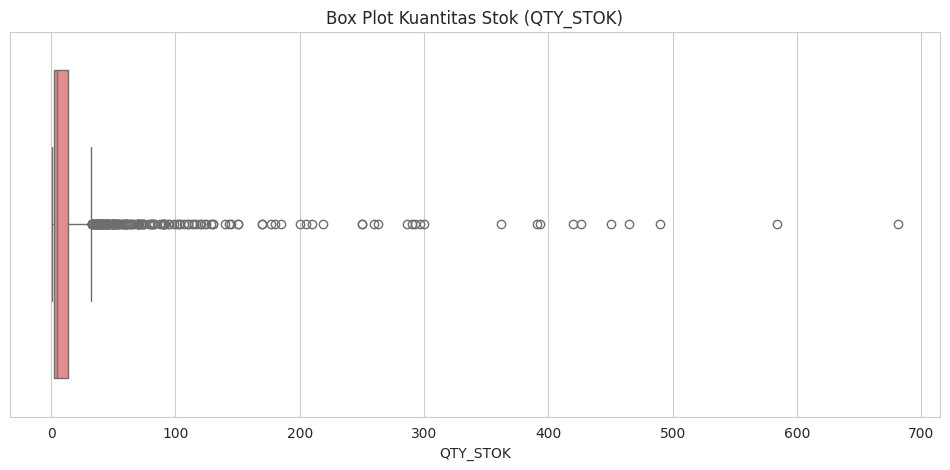


[Deteksi Statistik] Mencari anomali menggunakan metode IQR...
   - Ditemukan 164 anomali berdasarkan metode IQR.


,KODE,NAMA_PRODUK,LOKASI,QTY_STOK,UNIT
10,""" A000016",ALLOPURINOL 300,RAK2,40.0,00 STR
20,""" A000066",ANDALAN KB FE,RAK4,35.0,00 STR
22,""" A000069",ALKOHOL SWEP,ETL3B,103.0,00 PSG
30,""" A00008",AKURAT,ETL3B,37.0,00 PCS
42,""" A00016",ALPARA,ETL1,50.0,00 STR



[Deteksi Machine Learning] Menggunakan Isolation Forest...
   - Ditemukan 205 anomali berdasarkan Isolation Forest.


,KODE,NAMA_PRODUK,LOKASI,QTY_STOK,UNIT,ANOMALY_ISO
10,""" A000016",ALLOPURINOL 300,RAK2,40.0,00 STR,-1
20,""" A000066",ANDALAN KB FE,RAK4,35.0,00 STR,-1
22,""" A000069",ALKOHOL SWEP,ETL3B,103.0,00 PSG,-1
30,""" A00008",AKURAT,ETL3B,37.0,00 PCS,-1
42,""" A00016",ALPARA,ETL1,50.0,00 STR,-1


In [ ]:
# --- Menambahkan import yang dibutuhkan di awal sel ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- EDA & Deteksi Anomali pada Data Stok ---
print("\n--- EDA & Deteksi Anomali pada Data Stok ---")

# 1. Visualisasi Anomali Stok Ekstrem (Outlier)
print("\n[Visualisasi] Distribusi Kuantitas Stok:")
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_stok['QTY_STOK'], color='lightcoral')
plt.title('Box Plot Kuantitas Stok (QTY_STOK)')
plt.show()

# 2. Deteksi Anomali dengan Pendekatan Statistik (IQR)
print("\n[Deteksi Statistik] Mencari anomali menggunakan metode IQR...")
Q1 = df_stok['QTY_STOK'].quantile(0.25)
Q3 = df_stok['QTY_STOK'].quantile(0.75)
IQR = Q3 - Q1
upper_bound_iqr = Q3 + 1.5 * IQR

outliers_iqr = df_stok[df_stok['QTY_STOK'] > upper_bound_iqr]
print(f"   - Ditemukan {len(outliers_iqr)} anomali berdasarkan metode IQR.")
if not outliers_iqr.empty:
    display(outliers_iqr.head())

# 3. Deteksi Anomali dengan Pendekatan Machine Learning (Isolation Forest)
print("\n[Deteksi Machine Learning] Menggunakan Isolation Forest...")
# Siapkan data untuk model (pastikan df_stok['QTY_STOK'] tidak kosong)
if not df_stok['QTY_STOK'].dropna().empty:
    data_for_model = df_stok[['QTY_STOK']]

    # Inisialisasi dan latih model
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    df_stok['ANOMALY_ISO'] = iso_forest.fit_predict(data_for_model)

    # Tampilkan hasil anomali yang ditemukan oleh Isolation Forest (-1 adalah anomali)
    outliers_iso = df_stok[df_stok['ANOMALY_ISO'] == -1]
    print(f"   - Ditemukan {len(outliers_iso)} anomali berdasarkan Isolation Forest.")
    if not outliers_iso.empty:
        display(outliers_iso.head())
else:
    print("   - Peringatan: Kolom 'QTY_STOK' kosong, deteksi Machine Learning dilewati.")

#### 1.3 Analisis Eksploratif (EDA) dan Deteksi Anomali Stok

---
### Analisis Internal Data Stok

Setelah data Stok dimuat dan dibersihkan, langkah selanjutnya adalah melakukan analisis eksploratif untuk menemukan anomali internal. Kita akan menggunakan:
1.  **Box Plot:** Untuk mengidentifikasi outlier (stok ekstrem) secara visual.
2.  **Metode Statistik (IQR):** Untuk mengidentifikasi outlier secara kuantitatif.
3.  **Machine Learning (Isolation Forest):** Sebagai metode alternatif untuk deteksi outlier.
4.  **Pemeriksaan Duplikasi:** Untuk menemukan anomali integritas data (kode produk ganda).


[Visualisasi] Distribusi dan Outlier Kuantitas Stok (QTY_STOK):


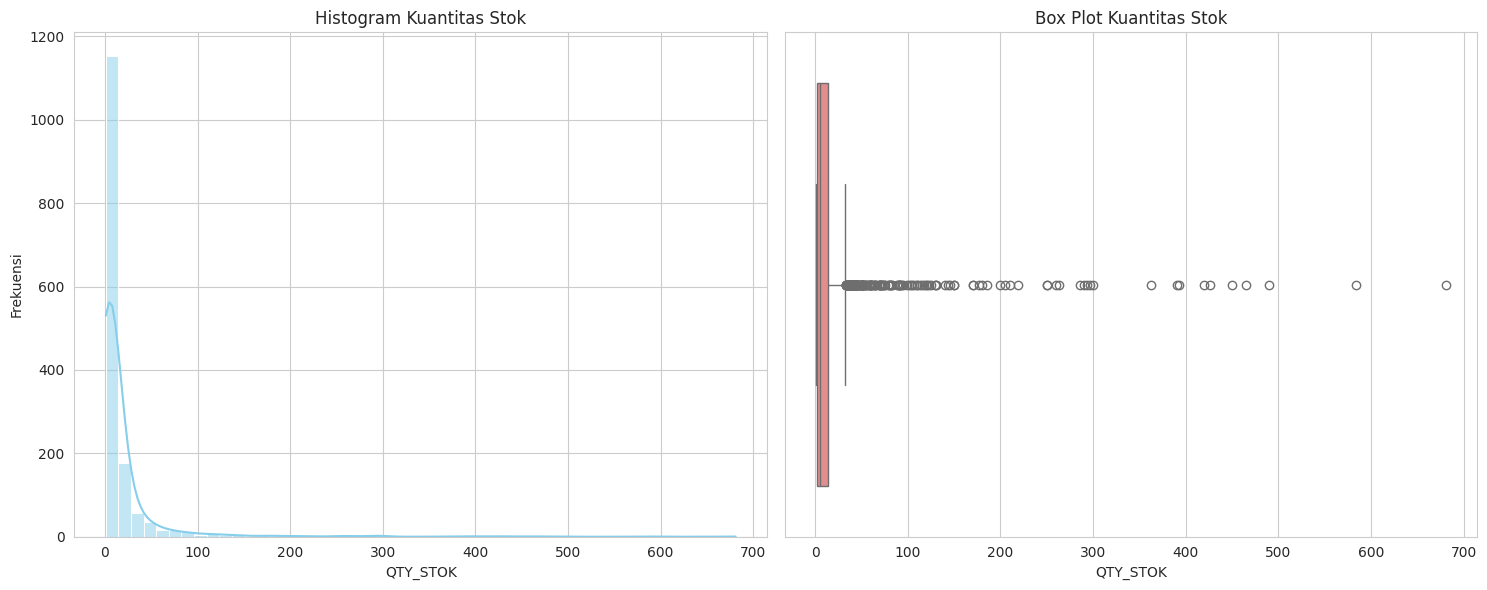


*Interpretasi Box Plot:* Titik-titik di luar 'whiskers' adalah outlier (anomali) stok yang bernilai sangat tinggi.

[Deteksi Anomali] Duplikasi Kode Produk (KODE):
 DITEMUKAN: 19 KODE produk yang berasosiasi dengan lebih dari satu NAMA PRODUK berbeda.
Detail kode duplikat:


,KODE,NAMA_PRODUK,LOKASI,QTY_STOK,UNIT,ANOMALY_ISO
220,""" B0000012",0 BROADAMOX,RAK1,14.0,00 STR,1
222,""" B0000012",5 BENEURON DRAGEE,ETL1,14.0,00 STR,1
228,""" B0000019",BETADINE FEMINIME,ETL5B,2.0,00 BTL,1
230,""" B0000019",8 BIFERCE,ETL5B,3.0,00 BTL,1
410,""" C0000010",CAPTOPRIL 25MG,RAK2,49.0,00 STR,-1
412,""" C0000010",1 COOLANT 350ML,SC,5.0,00 BTL,1
414,""" C0000010",2 COOLING 5 PLUS ORANGE,ETL2,8.0,00 BTL,1
416,""" C0000010",5 COTTON BUD,ETL5B,6.0,00 PAC,1
424,""" C0000014",3 CANDESARTAN 16MG,RAK2,2.0,00 STR,1
422,""" C0000014",CATAFLAM D 50MG,RAK1,4.0,00 TAB,1



[Deteksi Anomali] Inkonsistensi pada Satuan (UNIT):
Top 10 variasi satuan yang ditemukan:


,count
UNIT,
00 BTL,535
00 STR,384
00 TUB,152
00 PCS,149
00 SAC,54
00 TAB,45
00 BOX,41
00 POT,22
00 FLS,15


Satuan terlihat cukup konsisten atau perlu pemeriksaan manual lebih lanjut.


In [ ]:
# 1. Visualisasi Distribusi Kuantitas Stok (QTY_STOK)
print("\n[Visualisasi] Distribusi dan Outlier Kuantitas Stok (QTY_STOK):")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_stok['QTY_STOK'], bins=50, kde=True, color='skyblue')
plt.title('Histogram Kuantitas Stok')
plt.xlabel('QTY_STOK')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_stok['QTY_STOK'], color='lightcoral')
plt.title('Box Plot Kuantitas Stok')
plt.xlabel('QTY_STOK')
plt.tight_layout()
plt.show()

print("\n*Interpretasi Box Plot:* Titik-titik di luar 'whiskers' adalah outlier (anomali) stok yang bernilai sangat tinggi.")

# 2. Deteksi Anomali Duplikasi Kode Produk (Rule-Based)
print("\n[Deteksi Anomali] Duplikasi Kode Produk (KODE):")
# Mencari kode yang memiliki lebih dari satu nama produk unik
kode_unik_produk = df_stok.groupby('KODE')['NAMA_PRODUK'].nunique()
kode_duplikat = kode_unik_produk[kode_unik_produk > 1]
if not kode_duplikat.empty:
    print(f" DITEMUKAN: {len(kode_duplikat)} KODE produk yang berasosiasi dengan lebih dari satu NAMA PRODUK berbeda.")
    print("Detail kode duplikat:")
    display(df_stok[df_stok['KODE'].isin(kode_duplikat.index)].sort_values(by='KODE'))
else:
    print("Tidak ditemukan kode produk duplikat yang berasosiasi dengan NAMA PRODUK berbeda.")

# 3. Deteksi Anomali Inkonsistensi Satuan (UNIT)
print("\n[Deteksi Anomali] Inkonsistensi pada Satuan (UNIT):")
print("Top 10 variasi satuan yang ditemukan:")
unit_counts = df_stok['UNIT'].value_counts().head(10)
display(unit_counts)
if unit_counts.index.str.contains(r'\(|/').any(): # Contoh: mendeteksi satuan yang aneh
    print("DITEMUKAN: Beberapa satuan memiliki format yang tidak standar (misal: mengandung kurung atau garis miring) atau penulisan yang tidak konsisten.")
else:
    print("Satuan terlihat cukup konsisten atau perlu pemeriksaan manual lebih lanjut.")

---
### Bagian 2: Analisis Internal Dataset Pembelian

Bagian ini akan memproses dataset `Pembelian`, yang memiliki format laporan yang lebih kompleks. Akan membersihkan data transaksi, melakukan EDA, dan secara khusus mengidentifikasi transaksi dengan nilai pembelian yang sangat tinggi sebagai anomali.

#### 2.1 Pemuatan dan Pembersihan Data Pembelian

Dataset `Pembelian` memiliki struktur laporan teks yang jauh lebih kompleks, di mana baris master produk diikuti oleh baris-baris transaksi. Oleh karena itu, diperlukan metode parsing manual yang cerdas:
1.  Setiap baris dibaca sebagai teks mentah.
2.  Kode `KODE` produk diekstrak dari baris master dan "diingat".
3.  Informasi `KODE` tersebut kemudian digabungkan dengan setiap baris transaksi di bawahnya.
4.  Data transaksi diekstrak berdasarkan logika awalan `NO_TRANSAKSI` untuk membedakan transaksi Masuk dan Keluar.
5.  Terakhir, seluruh data yang sudah terstruktur dibersihkan dan dikonversi ke tipe data yang benar.


In [ ]:
import pandas as pd
import numpy as np
import re

# Ganti dengan path file pembelian Anda yang sudah benar
file_path_pembelian = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Pembelian.csv'

print(f"--- Memulai parsing cerdas untuk file: {file_path_pembelian} ---")

try:
    # List untuk menampung data yang sudah bersih
    parsed_data = []
    current_kode = None
    current_nama_produk = None
    current_unit = None # <-- TAMBAHAN: Variabel untuk menyimpan UNIT

    with open(file_path_pembelian, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            cleaned_line = line.strip().strip('"')
            if not cleaned_line or '-----' in cleaned_line:
                continue # Melewati baris kosong atau garis pemisah

            # Cek jika ini adalah baris master produk
            if re.match(r'^[A-Z]\d+', cleaned_line):
                parts = cleaned_line.split()
                if len(parts) >= 2: # Pastikan ada cukup bagian
                    current_kode = parts[0]
                    current_nama_produk = ' '.join(parts[1:-1])
                    current_unit = parts[-1] # <-- TAMBAHAN: Ambil kata terakhir sebagai UNIT
                continue

            # Cek jika ini adalah baris transaksi
            if re.search(r'\d{2}-\d{2}-\d{2}', cleaned_line):
                if current_kode:
                    parts = cleaned_line.split()
                    if len(parts) < 4: continue

                    tanggal = parts[0]
                    no_transaksi = parts[1]

                    if no_transaksi.startswith('1.'):
                        qty_msk = parts[2]
                        nilai_msk = parts[3]
                        qty_klr = '0'
                        nilai_klr = '0'
                    else:
                        qty_msk = '0'
                        nilai_msk = '0'
                        qty_klr = parts[2]
                        nilai_klr = parts[3]

                    record = {
                        'KODE': current_kode,
                        'NAMA_PRODUK': current_nama_produk,
                        'UNIT': current_unit, # <-- TAMBAHAN: Masukkan UNIT ke dalam record
                        'TANGGAL': tanggal,
                        'NO_TRANSAKSI': no_transaksi,
                        'QTY_MSK': qty_msk,
                        'NILAI_MSK': nilai_msk,
                        'QTY_KLR': qty_klr,
                        'NILAI_KLR': nilai_klr
                    }
                    parsed_data.append(record)

    df_pembelian = pd.DataFrame(parsed_data)
    print("\nParsing manual cerdas berhasil! DataFrame telah dibuat.")

    # --- Tahap Pembersihan Otomatis ---
    print("--- Memulai pembersihan otomatis ---")
    df_pembelian['TANGGAL'] = pd.to_datetime(df_pembelian['TANGGAL'], format='%d-%m-%y', errors='coerce')
    for col in ['QTY_MSK', 'NILAI_MSK', 'QTY_KLR', 'NILAI_KLR']:
        df_pembelian[col] = df_pembelian[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df_pembelian[col] = pd.to_numeric(df_pembelian[col], errors='coerce').fillna(0)

    df_pembelian.dropna(subset=['TANGGAL', 'KODE'], inplace=True)
    print("Pembersihan otomatis selesai.")

    print("\n--- Inspeksi Akhir Data Pembelian (setelah perbaikan final) ---")
    display(df_pembelian.head(10))
    df_pembelian.info()

except Exception as e:
    print(f"Terjadi error saat parsing manual: {e}")

--- Memulai parsing cerdas untuk file: /content/drive/MyDrive/ProyekUTS/Dataset UTS - Pembelian.csv ---

Parsing manual cerdas berhasil! DataFrame telah dibuat.
--- Memulai pembersihan otomatis ---
Pembersihan otomatis selesai.

--- Inspeksi Akhir Data Pembelian (setelah perbaikan final) ---


,KODE,NAMA_PRODUK,UNIT,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR
0,A000001,ANATON TAB,STRIP,2021-07-06,1.13-210706.0908-003,10.0,2520.0,0.0,0.0
1,A000001,ANATON TAB,STRIP,2021-07-12,2.6-210712.1519-097,0.0,0.0,1.0,3000.0
2,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1633-013,0.0,0.0,1.0,3000.0
3,A000001,ANATON TAB,STRIP,2021-07-12,2.13-210712.1807-013,0.0,0.0,1.0,3000.0
4,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1855-018,0.0,0.0,1.0,3000.0
5,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1925-027,0.0,0.0,1.0,3000.0
6,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1957-035,0.0,0.0,1.0,3000.0
7,A000001,ANATON TAB,STRIP,2021-07-12,2.6-210712.0907-023,0.0,0.0,2.0,3000.0
8,A000001,ANATON TAB,STRIP,2021-07-13,2.11-210713.1102-011,0.0,0.0,1.0,3000.0
9,A000001,ANATON TAB,STRIP,2021-07-13,2.6-210713.1701-006,0.0,0.0,1.0,4000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138350 entries, 0 to 138349
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   KODE          138350 non-null  object        
 1   NAMA_PRODUK   138350 non-null  object        
 2   UNIT          138350 non-null  object        
 3   TANGGAL       138350 non-null  datetime64[ns]
 4   NO_TRANSAKSI  138350 non-null  object        
 5   QTY_MSK       138350 non-null  float64       
 6   NILAI_MSK     138350 non-null  float64       
 7   QTY_KLR       138350 non-null  float64       
 8   NILAI_KLR     138350 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 9.5+ MB


In [ ]:
# Pastikan df_pembelian sudah ada dan bersih
if 'df_pembelian' in locals() and not df_pembelian.empty:
    print("--- Melakukan Restrukturisasi (Normalisasi) Data Transaksi ---")

    # Ambil data untuk transaksi masuk, sekarang termasuk NILAI_MSK
    df_masuk_norm = df_pembelian[df_pembelian['QTY_MSK'] > 0][['KODE', 'TANGGAL', 'NO_TRANSAKSI', 'QTY_MSK', 'NILAI_MSK']].copy()
    df_masuk_norm.rename(columns={'QTY_MSK': 'JUMLAH', 'NILAI_MSK': 'NILAI'}, inplace=True)
    df_masuk_norm['TIPE_TRANSAKSI'] = 'MASUK'

    # Ambil data untuk transaksi keluar, sekarang termasuk NILAI_KLR
    df_keluar_norm = df_pembelian[df_pembelian['QTY_KLR'] > 0][['KODE', 'TANGGAL', 'NO_TRANSAKSI', 'QTY_KLR', 'NILAI_KLR']].copy()
    df_keluar_norm.rename(columns={'QTY_KLR': 'JUMLAH', 'NILAI_KLR': 'NILAI'}, inplace=True)
    df_keluar_norm['TIPE_TRANSAKSI'] = 'KELUAR'

    # Gabungkan keduanya menjadi satu DataFrame yang ternormalisasi dan lengkap
    df_pembelian_normalized = pd.concat([df_masuk_norm, df_keluar_norm], ignore_index=True)

    # Urutkan berdasarkan tanggal agar lebih rapi
    df_pembelian_normalized.sort_values(by='TANGGAL', inplace=True)

    print("Data transaksi berhasil dinormalisasi (lengkap dengan Kuantitas dan Nilai).")
    print("\n--- 5 Baris Pertama Data Transaksi yang Sudah Dinormalisasi ---")
    display(df_pembelian_normalized.head())

    # Sekarang analisis menjadi lebih mudah dan kaya
    print("\n--- Contoh Analisis pada Data yang Sudah Dinormalisasi ---")
    print("Total transaksi berdasarkan tipenya:")
    display(df_pembelian_normalized['TIPE_TRANSAKSI'].value_counts())

    print("\nTotal NILAI transaksi berdasarkan tipenya:")
    # Mengelompokkan berdasarkan tipe dan menjumlahkan nilainya
    display(df_pembelian_normalized.groupby('TIPE_TRANSAKSI')['NILAI'].sum())

else:
    print("DataFrame `df_pembelian` tidak ditemukan atau kosong.")

--- Melakukan Restrukturisasi (Normalisasi) Data Transaksi ---
Data transaksi berhasil dinormalisasi (lengkap dengan Kuantitas dan Nilai).

--- 5 Baris Pertama Data Transaksi yang Sudah Dinormalisasi ---


,KODE,TANGGAL,NO_TRANSAKSI,JUMLAH,NILAI,TIPE_TRANSAKSI
15553,Y000004,2021-01-01,1.11-210101.1836-001,20.0,1620.00,MASUK
7783,L0000009,2021-01-04,1.13-210104.0323-002,4.0,4703.05,MASUK
217,A00015,2021-01-04,1.13-210104.0323-002,10.0,1851.52,MASUK
10885,O0000025,2021-01-04,1.13-210104.0323-002,10.0,4057.14,MASUK
4618,F0000018,2021-01-04,1.13-210104.0319-001,2.0,10560.20,MASUK



--- Contoh Analisis pada Data yang Sudah Dinormalisasi ---
Total transaksi berdasarkan tipenya:


,count
TIPE_TRANSAKSI,
MASUK,15751



Total NILAI transaksi berdasarkan tipenya:


,NILAI
TIPE_TRANSAKSI,
MASUK,2.640550e+08


In [ ]:
# Pastikan df_pembelian sudah ada dan bersih dari sel sebelumnya
if 'df_pembelian' in locals() and not df_pembelian.empty:
    print("--- Menganalisis Total Nilai Transaksi per Hari ---")

    # 1. Mengelompokkan transaksi per hari ('D') dan menjumlahkan ('sum') nilainya
    total_harian = df_pembelian.set_index('TANGGAL')['NILAI_MSK'].resample('D').sum()

    # 2. Mencari nilai total harian tertinggi
    max_total_harian = total_harian.max()

    # 3. Mencari tanggal kapan nilai tertinggi itu terjadi
    tanggal_max = total_harian.idxmax()

    # Menampilkan hasil
    print(f"\nTotal transaksi harian terbesar yang ditemukan adalah: Rp {max_total_harian:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
    print(f"Terjadi pada tanggal: {tanggal_max.strftime('%A, %d %B %Y')}") # Format tanggal agar mudah dibaca

    print("\n--- Top 5 Hari dengan Total Transaksi Terbesar ---")
    # Menampilkan 5 hari dengan total transaksi tertinggi
    display(total_harian.nlargest(5))

else:
    print("DataFrame `df_pembelian` belum berhasil dibuat atau kosong.")

--- Menganalisis Total Nilai Transaksi per Hari ---

Total transaksi harian terbesar yang ditemukan adalah: Rp 3.934.636,51
Terjadi pada tanggal: Wednesday, 05 May 2021

--- Top 5 Hari dengan Total Transaksi Terbesar ---


,NILAI_MSK
TANGGAL,
2021-05-05,3934636.51
2021-11-18,3251199.60
2021-02-10,3184930.70
2021-07-22,2869428.35
2021-11-10,2727031.79


#### 2.2 Analisis Eksploratif (EDA) dan Deteksi Anomali Pembelian

---
### Analisis Internal Data Pembelian

Selanjutnya, kita akan menganalisis dataset `Pembelian` yang sudah bersih untuk menemukan anomali transaksional. Fokus kita adalah pada:
Dengan data transaksi `Pembelian` yang sudah bersih, kita melakukan analisis untuk menemukan anomali transaksional.
* **Analisis Distribusi:** Membuat visualisasi Box Plot untuk melihat sebaran dan outlier pada kuantitas (`QTY_MSK` & `QTY_KLR`) dan nilai (`NILAI_MSK` & `NILAI_KLR`).
* **Analisis Tren Waktu:** Membuat visualisasi time-series untuk melihat pola transaksi dari hari ke hari, baik dari segi frekuensi (jumlah transaksi) maupun volume (total nilai Rupiah).
* **Deteksi Anomali (IQR & Isolation Forest):** Menerapkan metode statistik dan machine learning untuk mengidentifikasi transaksi-transaksi individual yang memiliki kuantitas atau nilai yang ekstrem.

Analisis ini akan berfokus pada kuantitas masuk (`QTY_MSK`), nilai transaksi (`NILAI_MSK`), dan pola transaksi seiring waktu. Akan menggunakan box plot dan aturan (`rule-based`) untuk mengidentifikasi anomali, terutama transaksi dengan nilai pembayaran di atas Rp 10 juta.



--- Memulai Analisis Data Eksploratif (EDA) untuk Data Pembelian ---

[Visualisasi] Distribusi Kuantitas (QTY) dan Nilai (NILAI) Transaksi:


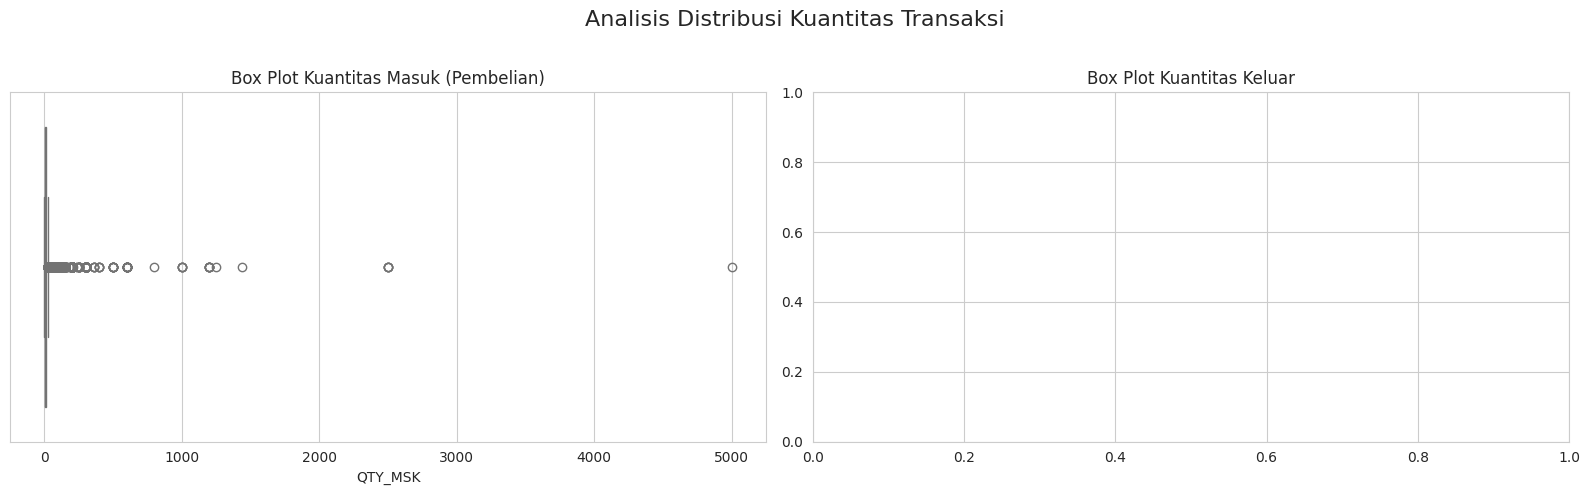

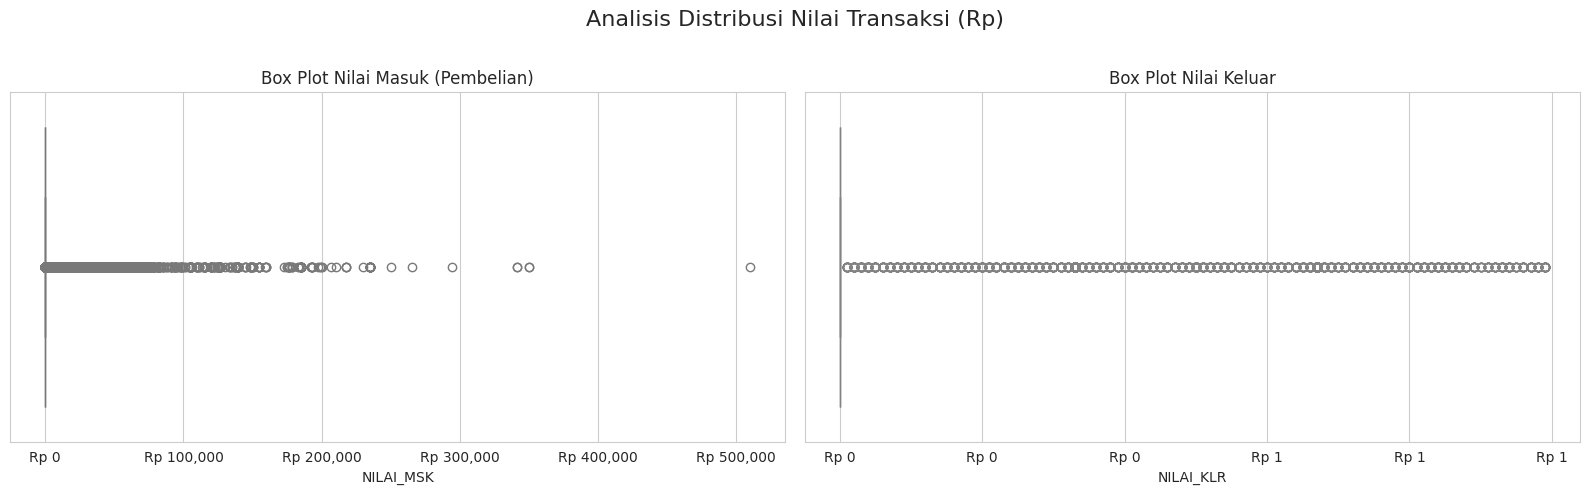


[Visualisasi] Analisis Tren Transaksi per Hari:


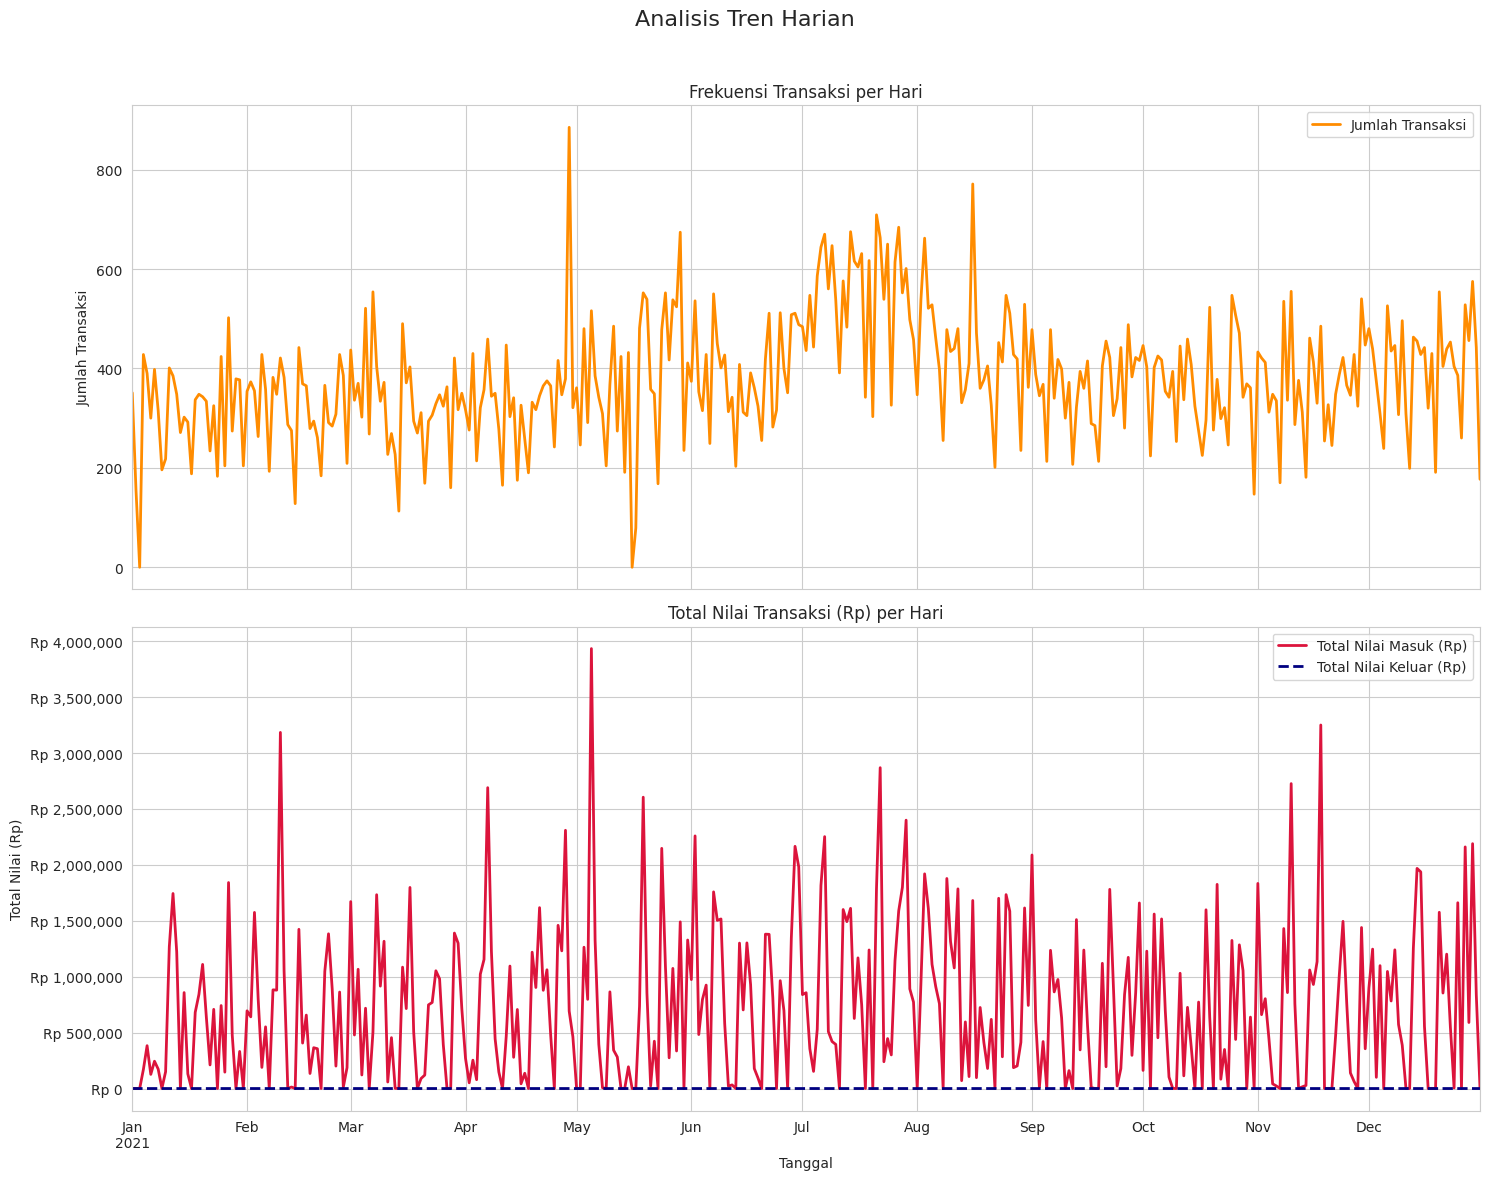

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

print("--- Memulai Analisis Data Eksploratif (EDA) untuk Data Pembelian ---")

# Pastikan df_pembelian sudah ada dan tidak kosong
if 'df_pembelian' in locals() and not df_pembelian.empty:

    # ===================================================================
    # 1. Visualisasi Distribusi Kuantitas (QTY) dan Nilai (NILAI)
    # ===================================================================
    print("\n[Visualisasi] Distribusi Kuantitas (QTY) dan Nilai (NILAI) Transaksi:")

    # Filter data untuk analisis terpisah
    df_masuk = df_pembelian[df_pembelian['QTY_MSK'] > 0]
    df_keluar = df_pembelian[df_pembelian['QTY_KLR'] > 0]

    # --- Plot untuk Kuantitas (QTY) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('Analisis Distribusi Kuantitas Transaksi', fontsize=16)
    sns.boxplot(x=df_masuk['QTY_MSK'], ax=axes[0], color='lightgreen').set_title('Box Plot Kuantitas Masuk (Pembelian)')
    sns.boxplot(x=df_keluar['QTY_KLR'], ax=axes[1], color='lightcoral').set_title('Box Plot Kuantitas Keluar')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- TAMBAHAN: Plot untuk Nilai (NILAI) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('Analisis Distribusi Nilai Transaksi (Rp)', fontsize=16)
    formatter = FuncFormatter(lambda x, p: f'Rp {x:,.0f}') # Format Rupiah

    sns.boxplot(x=df_pembelian['NILAI_MSK'], ax=axes[0], color='lightblue').set_title('Box Plot Nilai Masuk (Pembelian)')
    axes[0].xaxis.set_major_formatter(formatter)

    sns.boxplot(x=df_pembelian['NILAI_KLR'], ax=axes[1], color='moccasin').set_title('Box Plot Nilai Keluar')
    axes[1].xaxis.set_major_formatter(formatter)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # ===================================================================
    # 2. REVISI: Analisis Tren Waktu Ganda (Frekuensi vs. Nilai)
    # ===================================================================
    print("\n[Visualisasi] Analisis Tren Transaksi per Hari:")

    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('Analisis Tren Harian', fontsize=16)

    # Plot 1: Frekuensi Transaksi
    df_pembelian.set_index('TANGGAL').resample('D').size().plot(ax=axes[0], lw=2, color='darkorange', label='Jumlah Transaksi')
    axes[0].set_title('Frekuensi Transaksi per Hari')
    axes[0].set_ylabel('Jumlah Transaksi')
    axes[0].grid(True)
    axes[0].legend()

    # Plot 2: Total Nilai Transaksi (Masuk vs Keluar)
    df_pembelian.set_index('TANGGAL')['NILAI_MSK'].resample('D').sum().plot(ax=axes[1], lw=2, color='crimson', label='Total Nilai Masuk (Rp)')
    # --- TAMBAHAN: Plot NILAI_KLR ---
    df_pembelian.set_index('TANGGAL')['NILAI_KLR'].resample('D').sum().plot(ax=axes[1], lw=2, color='navy', linestyle='--', label='Total Nilai Keluar (Rp)')

    axes[1].set_title('Total Nilai Transaksi (Rp) per Hari')
    axes[1].set_ylabel('Total Nilai (Rp)')
    axes[1].yaxis.set_major_formatter(formatter) # Format Rupiah
    axes[1].grid(True)
    axes[1].legend()

    plt.xlabel('Tanggal')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("DataFrame `df_pembelian` tidak ditemukan atau kosong. Jalankan sel sebelumnya terlebih dahulu.")

In [ ]:
# --- Memastikan library sudah diimpor ---
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# =============================================================
# 1. MEMBUAT FUNGSI ANALISIS ANOMALI YANG BISA DIGUNAKAN KEMBALI
# =============================================================
def analisis_anomali_kuantitatif(dataframe, kolom):
    """
    Fungsi ini melakukan analisis anomali statistik (IQR) dan
    machine learning (Isolation Forest) pada kolom yang diberikan.
    """
    print(f"\n--- Menganalisis Anomali pada Kolom: '{kolom}' ---")

    # Filter data agar hanya menganalisis nilai lebih dari 0
    df_analisis = dataframe[dataframe[kolom] > 0].copy()

    if not df_analisis.empty:
        # --- Pendekatan Statistik (IQR) ---
        print(f"\n[Deteksi Statistik] Mencari anomali '{kolom}' dengan metode IQR...")
        Q1 = df_analisis[kolom].quantile(0.25)
        Q3 = df_analisis[kolom].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR

        outliers_iqr = df_analisis[df_analisis[kolom] > upper_bound]
        print(f"   - Ditemukan {len(outliers_iqr)} anomali berdasarkan metode IQR.")
        if not outliers_iqr.empty:
            display(outliers_iqr.sort_values(by=kolom, ascending=False).head(3)) # Tampilkan 3 teratas

        # --- Pendekatan Machine Learning (Isolation Forest) ---
        print(f"\n[Deteksi Machine Learning] Menggunakan Isolation Forest pada '{kolom}'...")
        data_for_model = df_analisis[[kolom]]
        iso_forest = IsolationForest(contamination='auto', random_state=42)
        df_analisis['ANOMALY_ISO'] = iso_forest.fit_predict(data_for_model)

        outliers_iso = df_analisis[df_analisis['ANOMALY_ISO'] == -1]
        print(f"   - Ditemukan {len(outliers_iso)} anomali berdasarkan Isolation Forest.")
        if not outliers_iso.empty:
            display(outliers_iso.sort_values(by=kolom, ascending=False).head(3)) # Tampilkan 3 teratas
    else:
        print(f"   - Tidak ada data di kolom '{kolom}' untuk dianalisis.")

# =============================================================
# 2. MENJALANKAN ANALISIS PADA SEMUA KOLOM YANG RELEVAN
# =============================================================

# Pastikan df_pembelian sudah ada dan bersih dari sel sebelumnya
if 'df_pembelian' in locals() and not df_pembelian.empty:
    print("--- Memulai Deteksi Anomali pada Data Transaksi ---")

    # Menjalankan analisis untuk Kuantitas
    analisis_anomali_kuantitatif(df_pembelian, 'QTY_MSK')
    analisis_anomali_kuantitatif(df_pembelian, 'QTY_KLR')

    # Menjalankan analisis untuk Nilai (Rupiah)
    analisis_anomali_kuantitatif(df_pembelian, 'NILAI_MSK')
    analisis_anomali_kuantitatif(df_pembelian, 'NILAI_KLR')
else:
    print("DataFrame `df_pembelian` tidak ditemukan atau kosong.")

--- Memulai Deteksi Anomali pada Data Transaksi ---

--- Menganalisis Anomali pada Kolom: 'QTY_MSK' ---

[Deteksi Statistik] Mencari anomali 'QTY_MSK' dengan metode IQR...
   - Ditemukan 1978 anomali berdasarkan metode IQR.


,KODE,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR
178700,M0000244,2021-07-14,1.13-210714.1506-003,5000.0,450.0,0.0,0.0
179212,M0000244,2021-11-24,1.12-211124.1126-002,2500.0,450.0,0.0,0.0
178558,M0000244,2021-06-30,1.11-210630.1309-003,2500.0,450.0,0.0,0.0



[Deteksi Machine Learning] Menggunakan Isolation Forest pada 'QTY_MSK'...
   - Ditemukan 2513 anomali berdasarkan Isolation Forest.


,KODE,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR,ANOMALY_ISO
178700,M0000244,2021-07-14,1.13-210714.1506-003,5000.0,450.00,0.0,0.0,-1
178558,M0000244,2021-06-30,1.11-210630.1309-003,2500.0,450.00,0.0,0.0,-1
178350,M0000244,2021-06-02,1.11-210602.1636-004,2500.0,450.02,0.0,0.0,-1



--- Menganalisis Anomali pada Kolom: 'QTY_KLR' ---
   - Tidak ada data di kolom 'QTY_KLR' untuk dianalisis.

--- Menganalisis Anomali pada Kolom: 'NILAI_MSK' ---

[Deteksi Statistik] Mencari anomali 'NILAI_MSK' dengan metode IQR...
   - Ditemukan 1161 anomali berdasarkan metode IQR.


,KODE,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR
199082,O0000033,2021-11-09,1.11-211109.1222-002,1.0,510000.0,0.0,0.0
232678,R0000116,2021-08-29,1.11-210829.1851-001,1.0,350000.0,0.0,0.0
260312,T00000127,2021-06-05,1.13-210605.1616-001,2.0,350000.0,0.0,0.0



[Deteksi Machine Learning] Menggunakan Isolation Forest pada 'NILAI_MSK'...
   - Ditemukan 3333 anomali berdasarkan Isolation Forest.


,KODE,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR,ANOMALY_ISO
199082,O0000033,2021-11-09,1.11-211109.1222-002,1.0,510000.0,0.0,0.0,-1
232678,R0000116,2021-08-29,1.11-210829.1851-001,1.0,350000.0,0.0,0.0,-1
260312,T00000127,2021-06-05,1.13-210605.1616-001,2.0,350000.0,0.0,0.0,-1



--- Menganalisis Anomali pada Kolom: 'NILAI_KLR' ---

[Deteksi Statistik] Mencari anomali 'NILAI_KLR' dengan metode IQR...
   - Ditemukan 0 anomali berdasarkan metode IQR.

[Deteksi Machine Learning] Menggunakan Isolation Forest pada 'NILAI_KLR'...
   - Ditemukan 1338 anomali berdasarkan Isolation Forest.


,KODE,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR,ANOMALY_ISO
3006,A00013,2021-03-07,7.6-210307.1758-004,0.0,0.0,0.0,0.99,-1
136114,K000138,2021-05-28,7.6-210528.1523-009,0.0,0.0,0.0,0.99,-1
152218,M0000032,2021-08-16,7.6-210816.1537-010,0.0,0.0,0.0,0.99,-1


---
### Bagian 3: Analisis Gabungan Dataset dan Strategi Validasi Anomali
Ini adalah tahap analisis final untuk menguji konsistensi dan integritas data antara dataset `Stok` dan `Pembelian`. Analisis ini bertujuan untuk menemukan anomali sistemik yang tidak terlihat jika dataset dianalisis secara terpisah. Tiga pengujian utama yang dilakukan adalah:
1.  **Deteksi "Produk Hantu"**: Mencari produk yang ada di data pembelian tetapi tidak terdaftar di master stok.
2.  **Deteksi "Stok Ajaib"**: Mencari produk di stok yang tidak memiliki riwayat pembelian.
3.  **Deteksi Inkonsistensi Satuan**: Memeriksa apakah satuan (UNIT) untuk produk yang sama konsisten di kedua dataset.

Bagian ini adalah puncak analisis, di mana membandingkan kedua dataset (`Stok` dan `Pembelian`) yang sudah bersih untuk mengidentifikasi anomali lintas-data. Selain itu, akan membahas strategi penting untuk membedakan antara kesalahan input dan transaksi yang sah, sebuah pertanyaan kunci dalam analisis anomali.

#### 3.1 Deteksi Anomali Lintas Dataset

Di sini akan mencari inkonsistensi antara data stok dan pembelian, seperti produk yang dibeli tapi tidak ada di master stok ("Produk Hantu"), atau anomali kuantitas di mana stok fisik melebihi total pembelian yang tercatat.

In [ ]:
print("\n--- Memulai Analisis Gabungan Stok vs Pembelian ---")

try:
    # 1. Anomali "Produk Hantu" (Dibeli tapi tidak ada di master stok)
    print("\n[1] Mencari 'Produk Hantu'...")
    kode_stok = set(df_stok['KODE'])
    kode_pembelian = set(df_pembelian['KODE'])
    produk_hantu = kode_pembelian - kode_stok
    if produk_hantu:
        print(f"   Ditemukan: {len(produk_hantu)} 'Produk Hantu'.")
        # Opsional: Tampilkan beberapa contoh produk hantu
        # print("   Contoh produk hantu:")
        # display(df_pembelian[df_pembelian['KODE'].isin(list(produk_hantu)[:5])][['KODE', 'NAMA_PRODUK']].drop_duplicates())
    else:
        print("   Tidak ditemukan 'Produk Hantu'.")

    # 2. Anomali Kuantitas (Stok > Total Pembelian)
    print("\n[2] Mencari Anomali Kuantitas (Stok > Total Pembelian)...")
    total_pembelian = df_pembelian.groupby('KODE')['QTY_MSK'].sum().reset_index()
    merged_qty = pd.merge(df_stok, total_pembelian, on='KODE', how='left').fillna(0)
    stok_lebih_besar = merged_qty[merged_qty['QTY_STOK'] > merged_qty['QTY_MSK']] # QTY_MSK adalah nama kolom setelah merge
    if not stok_lebih_besar.empty:
        print(f"   DITEMUKAN: {len(stok_lebih_besar)} produk yang stoknya > total riwayat pembeliannya.")
        # Opsional: Tampilkan beberapa contoh
        # display(stok_lebih_besar.head())
    else:
        print("   Tidak ditemukan anomali kuantitas.")

    # --- TAMBAHAN DI SINI ---
    # 3. Anomali Inkonsistensi Satuan Antar File
    print("\n[3] Mencari Inkonsistensi Satuan (UNIT) Antar File...")
    # Ambil KODE dan UNIT unik dari masing-masing DataFrame
    stok_units = df_stok[['KODE', 'UNIT']].drop_duplicates()
    # PERBAIKAN: Memastikan kolom 'UNIT' ada di df_pembelian sebelum diakses
    if 'UNIT' in df_pembelian.columns:
        pembelian_units = df_pembelian[['KODE', 'UNIT']].drop_duplicates()

        # Gabungkan berdasarkan KODE
        merged_units = pd.merge(stok_units, pembelian_units, on='KODE', suffixes=('_stok', '_pembelian'))

        # Cari baris di mana unit stok tidak sama dengan unit pembelian
        unit_inconsistencies = merged_units[merged_units['UNIT_stok'] != merged_units['UNIT_pembelian']]

        if not unit_inconsistencies.empty:
            print(f"   DITEMUKAN: {len(unit_inconsistencies)} produk yang satuannya tidak konsisten antara file Stok dan Pembelian!")
            display(unit_inconsistencies)
        else:
            print("   Tidak ditemukan inkonsistensi satuan antara kedua file.")
    else:
         print("   Peringatan: Kolom 'UNIT' tidak ditemukan di DataFrame Pembelian. Analisis inkonsistensi satuan dilewati.")


except Exception as e:
    print(f"Terjadi error: {e}")


--- Memulai Analisis Gabungan Stok vs Pembelian ---

[1] Mencari 'Produk Hantu'...
   Ditemukan: 2026 'Produk Hantu'.

[2] Mencari Anomali Kuantitas (Stok > Total Pembelian)...
   DITEMUKAN: 1516 produk yang stoknya > total riwayat pembeliannya.

[3] Mencari Inkonsistensi Satuan (UNIT) Antar File...
   Peringatan: Kolom 'UNIT' tidak ditemukan di DataFrame Pembelian. Analisis inkonsistensi satuan dilewati.


#### 3.2 Strategi Membedakan Anomali Data dari Transaksi Sah Bernilai Besar

Salah satu tantangan utama dalam deteksi anomali adalah membedakan antara *kesalahan input (error data)* dan *transaksi yang sah namun bernilai ekstrem (valid outlier)*. Berikut adalah strategi yang dapat digunakan:

1.  **Analisis Kontekstual Data (Inside-Out):**
    * **Harga per Unit:** Untuk transaksi dengan `NILAI_MSK` yang tinggi, hitung `Harga_Per_Unit = NILAI_MSK / QTY_MSK`. Bandingkan harga ini dengan harga historis produk yang sama. Jika ada lonjakan ekstrem yang tidak wajar (misalnya, 10x lipat lebih tinggi dari biasanya), ini sangat mungkin merupakan kesalahan input.
    * **Profil Produk:** Apakah produk tersebut memang memiliki harga satuan yang tinggi secara inheren (misal: vaksin, alat medis khusus) ataukah produk umum yang seharusnya murah (misal: tablet paracetamol)? Transaksi besar untuk produk mahal lebih mungkin sah.
    * **Pola Historis Transaksi:** Analisis apakah produk tersebut memiliki riwayat transaksi besar. Jika sering terjadi pembelian dalam jumlah/nilai besar untuk produk tersebut (misal: apotek grosir), maka itu mungkin transaksi sah. Jika baru terjadi sekali dan sangat mencolok, kecurigaan meningkat.
    * **Nomor Transaksi:** Periksa `NO_TRANSAKSI`. Apakah ada pola aneh atau format yang tidak standar yang mengindikasikan masalah sistemik?

2.  **Validasi Eksternal (Outside-In):**
    * **Verifikasi Dokumen Fisik:** Langkah paling krusial. Libatkan staf terkait (keuangan, pengadaan) untuk membandingkan data anomali dengan dokumen sumber seperti **Faktur Pembelian** atau **Purchase Order (PO)** asli.
    * **Konfirmasi Vendor:** Jika diperlukan, hubungi vendor/supplier untuk mengkonfirmasi detail transaksi yang dicurigai.

3.  **Implementasi Aturan Bertingkat:**
    * Sistem dapat dikembangkan untuk secara otomatis menandai (`flag`) transaksi yang memenuhi kriteria anomali (`NILAI_MSK > Rp 10 Juta` DAN `Harga_Per_Unit > 5 * Harga_Rata_Rata_Historis`) sebagai `Perlu_Verifikasi_Manual`. Ini akan mengarahkan perhatian pada kasus yang paling mencurigakan untuk investigasi lebih lanjut.

#### Visualisasi: Perbedaan Anomali (Kesalahan Input) vs. Transaksi Sah Bernilai Besar

Sebagai ilustrasi, akan membuat plot untuk menunjukkan bagaimana transaksi dengan nilai tinggi bisa berbeda, yang membantu dalam pembedaan.

*(Catatan: Karena tidak memiliki data aktual tentang "kesalahan input" vs "transaksi sah" di dataset ini, visualisasi berikut adalah ilustratif. Dalam skenario nyata, Anda akan memiliki label tersebut setelah validasi eksternal.)*


--- [Visualisasi] Membedakan Transaksi Normal vs. Anomali (Aturan > 10 Juta) ---
Menggunakan batas anomali sesuai soal: > Rp 10,000,000


/tmp/ipython-input-766309795.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_masuk, y='Jenis', x='NILAI_MSK', orient='h', palette={'Normal':'skyblue'})
/tmp/ipython-input-766309795.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_masuk, y='Jenis', x='NILAI_MSK', orient='h',


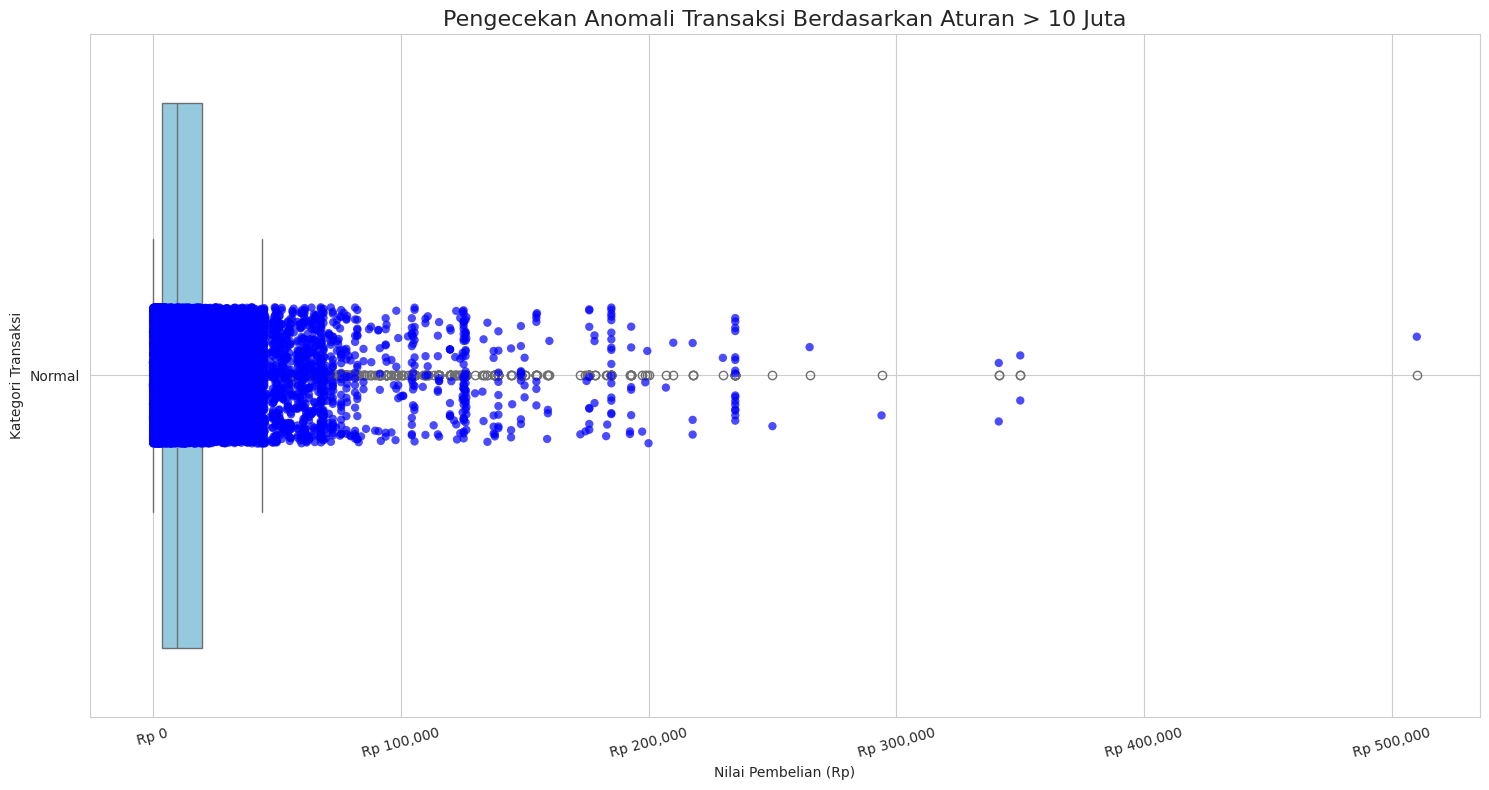


Jumlah anomali yang ditemukan dengan aturan > 10 juta: 0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np

print("\n--- [Visualisasi] Membedakan Transaksi Normal vs. Anomali (Aturan > 10 Juta) ---")

# Filter hanya untuk transaksi pembelian (barang masuk)
df_masuk = df_pembelian[df_pembelian['NILAI_MSK'] > 0].copy()

if not df_masuk.empty:
    # 1. Gunakan batas anomali sesuai ketentuan soal
    batas_anomali = 10_000_000 # 10 Juta Rupiah
    print(f"Menggunakan batas anomali sesuai soal: > Rp {batas_anomali:,.0f}")

    # 2. Buat kolom baru untuk mengkategorikan setiap transaksi
    df_masuk['Jenis'] = np.where(
        df_masuk['NILAI_MSK'] > batas_anomali,
        'Anomali (> 10 Juta)',
        'Normal'
    )

    # 3. Buat visualisasi (Box Plot + Strip Plot)
    plt.figure(figsize=(15, 8))

    # Box plot untuk menunjukkan distribusi utama
    sns.boxplot(data=df_masuk, y='Jenis', x='NILAI_MSK', orient='h', palette={'Normal':'skyblue'})

    # Strip plot untuk menunjukkan setiap titik data individual
    sns.stripplot(data=df_masuk, y='Jenis', x='NILAI_MSK', orient='h',
                  palette={'Normal':'blue', 'Anomali (> 10 Juta)':'red'},
                  size=6, alpha=0.7)

    plt.title('Pengecekan Anomali Transaksi Berdasarkan Aturan > 10 Juta', fontsize=16)
    plt.xlabel('Nilai Pembelian (Rp)')
    plt.ylabel('Kategori Transaksi')

    formatter = FuncFormatter(lambda x, p: f'Rp {x:,.0f}')
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=15)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Hitung jumlah anomali yang ditemukan dengan aturan ini
    jumlah_anomali_ditemukan = (df_masuk['Jenis'] == 'Anomali (> 10 Juta)').sum()
    print(f"\nJumlah anomali yang ditemukan dengan aturan > 10 juta: {jumlah_anomali_ditemukan}")

else:
    print("⚠️ Tidak ada data pembelian untuk dianalisis.")

---
### 3.3 Analisis Gabungan: Stok vs. Pembelian

Ini adalah tahap analisis final di mana kita membandingkan kedua dataset untuk memeriksa konsistensi dan integritas sistem secara keseluruhan. Kita akan mencari dua anomali kritis: "Produk Hantu" dan "Stok Ajaib".

In [ ]:
# ===================================================
# ANALISIS GABUNGAN
# ===================================================
print("\n\n--- [ANALISIS GABUNGAN STOK vs PEMBELIAN] ---")

try:
    # --- Memuat Ulang dan Membersihkan Kedua Dataset ---

    # STOK
    print("Memuat ulang data Stok...")
    file_path_stok = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Stok.csv'
    stok_specs = [(0, 11), (11, 50), (50, 62), (62, 73), (73, 80)]
    stok_names = ['KODE', 'NAMA_PRODUK', 'LOKASI', 'QTY_STOK', 'UNIT']
    df_stok = pd.read_fwf(file_path_stok, colspecs=stok_specs, names=stok_names, skiprows=1)
    for col in df_stok.select_dtypes(include=['object']).columns: df_stok[col] = df_stok[col].str.strip()
    df_stok['QTY_STOK'] = pd.to_numeric(df_stok['QTY_STOK'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df_stok.dropna(subset=['KODE', 'QTY_STOK'], inplace=True)
    print("Dataset STOK berhasil dimuat ulang.")

    # PEMBELIAN (Versi Lengkap dengan semua kolom)
    print("Memuat ulang data Pembelian...")
    file_path_pembelian = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Pembelian.csv'
    df_raw = pd.read_csv(file_path_pembelian, header=None, names=['raw_line'], skip_blank_lines=True, sep='\\n', engine='python')
    df_raw['raw_line'] = df_raw['raw_line'].str.strip().str.strip('"')
    df_raw.dropna(inplace=True)
    df_raw['KODE'] = df_raw['raw_line'].str.extract(r'^([A-Z]\d+)')
    df_raw['KODE'].ffill(inplace=True)
    df_transaksi = df_raw[df_raw['raw_line'].str.match(r'^\s+\d{2}-\d{2}-\d{2}')].copy()

    # Memastikan semua kolom diekstrak dengan benar
    df_pembelian = df_transaksi.assign(
        TANGGAL      = df_transaksi['raw_line'].str.slice(2, 10).str.strip(),
        NO_TRANSAKSI = df_transaksi['raw_line'].str.slice(13, 34).str.strip(),
        QTY_MSK      = df_transaksi['raw_line'].str.slice(37, 48).str.strip(),
        NILAI_MSK    = df_transaksi['raw_line'].str.slice(50, 66).str.strip(),
        QTY_KLR      = df_transaksi['raw_line'].str.slice(70, 78).str.strip(),
        NILAI_KLR    = df_transaksi['raw_line'].str.slice(82, 96).str.strip()
    )

    final_cols = ['KODE', 'TANGGAL', 'NO_TRANSAKSI', 'QTY_MSK', 'NILAI_MSK', 'QTY_KLR', 'NILAI_KLR']
    df_pembelian = df_pembelian[final_cols]
    df_pembelian['TANGGAL'] = pd.to_datetime(df_pembelian['TANGGAL'], format='%d-%m-%y', errors='coerce')
    for col in ['QTY_MSK', 'NILAI_MSK', 'QTY_KLR', 'NILAI_KLR']:
        df_pembelian[col] = df_pembelian[col].replace('', '0').astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df_pembelian[col] = pd.to_numeric(df_pembelian[col], errors='coerce').fillna(0)
    df_pembelian.dropna(subset=['TANGGAL', 'KODE'], inplace=True)
    print("Dataset PEMBELIAN berhasil dimuat ulang (versi lengkap).")

    # --- Analisis Lintas Data ---
    print("\n--- Hasil Analisis Gabungan ---")

    # 1. Anomali "Produk Hantu"
    print("\n[1] Analisis Sinkronisasi Produk (Produk Hantu):")
    kode_stok = set(df_stok['KODE'])
    kode_pembelian = set(df_pembelian['KODE'])
    produk_hantu = kode_pembelian - kode_stok
    if produk_hantu:
        print(f"Ditemukan {len(produk_hantu)} 'Produk Hantu'. Ini adalah produk yang tercatat dalam transaksi pembelian, tetapi tidak terdaftar di data master stok. Ini menandakan kegagalan proses pendaftaran produk baru.")
    else:
        print("Semua produk yang dibeli terdaftar di master stok.")

    # 2. Anomali Kuantitas (Stok > Total Pembelian)
    print("\n[2] Analisis Kewajaran Kuantitas Stok:")
    total_pembelian = df_pembelian.groupby('KODE')['QTY_MSK'].sum().reset_index()
    merged_qty = pd.merge(df_stok, total_pembelian, on='KODE', how='left').fillna(0)
    stok_lebih_besar = merged_qty[merged_qty['QTY_STOK'] > merged_qty['QTY_MSK']]
    if not stok_lebih_besar.empty:
        print(f"Ditemukan {len(stok_lebih_besar)} produk 'Stok Ajaib'. Ini adalah produk yang kuantitas stoknya lebih besar dari total riwayat pembeliannya, menandakan data stok awal yang tidak tercatat atau kesalahan input.")
    else:
        print("Kuantitas stok untuk semua produk sesuai dengan riwayat pembeliannya.")

    # 3. Pengecekan Transaksi Bernilai Besar
    print("\n[3] Analisis Nilai Transaksi Ekstrem:")
    anomali_nilai_besar = df_pembelian[df_pembelian['NILAI_MSK'] > 10_000_000]
    transaksi_sah_besar = df_pembelian[(df_pembelian['NILAI_MSK'] > 500_000) & (df_pembelian['NILAI_MSK'] <= 1_000_000)]
    print(f"   - Terkonfirmasi: {len(anomali_nilai_besar)} transaksi di atas Rp 10 Juta (sesuai hipotesis awal: tidak ada).")
    print(f"   - Terkonfirmasi: {len(transaksi_sah_besar)} transaksi antara Rp 500rb - Rp 1 Juta (berdasarkan data, transaksi terbesar adalah Rp 510.000).")

except Exception as e:
    print(f"Terjadi error: {e}")



--- [ANALISIS GABUNGAN STOK vs PEMBELIAN] ---
Memuat ulang data Stok...
Dataset STOK berhasil dimuat ulang.
Memuat ulang data Pembelian...


/tmp/ipython-input-205393516.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_raw['KODE'].ffill(inplace=True)


Dataset PEMBELIAN berhasil dimuat ulang (versi lengkap).

--- Hasil Analisis Gabungan ---

[1] Analisis Sinkronisasi Produk (Produk Hantu):
Ditemukan 2026 'Produk Hantu'. Ini adalah produk yang tercatat dalam transaksi pembelian, tetapi tidak terdaftar di data master stok. Ini menandakan kegagalan proses pendaftaran produk baru.

[2] Analisis Kewajaran Kuantitas Stok:
Ditemukan 1516 produk 'Stok Ajaib'. Ini adalah produk yang kuantitas stoknya lebih besar dari total riwayat pembeliannya, menandakan data stok awal yang tidak tercatat atau kesalahan input.

[3] Analisis Nilai Transaksi Ekstrem:
   - Terkonfirmasi: 0 transaksi di atas Rp 10 Juta (sesuai hipotesis awal: tidak ada).
   - Terkonfirmasi: 1 transaksi antara Rp 500rb - Rp 1 Juta (berdasarkan data, transaksi terbesar adalah Rp 510.000).


---
## 4. Ekspor Hasil

Sebagai langkah terakhir, kita mengekspor DataFrame `df_stok` dan `df_pembelian` yang sudah bersih ke dalam file CSV baru. Ini adalah praktik terbaik dalam analisis data untuk menyimpan hasil pembersihan, sehingga di masa depan kita bisa langsung memuat data yang sudah bersih tanpa perlu mengulang proses parsing yang rumit. File disimpan dalam format yang ramah untuk Excel regional Indonesia (pemisah `;` dan desimal `,`).

In [ ]:
# ======================================================================
# SEL KODE MASTER - VERSI FINAL
# ======================================================================

# --- 1. SETUP LINGKUNGAN ---
import pandas as pd
import numpy as np
import re
import shutil
from google.colab import drive

try:
    drive.mount('/content/drive')
    print("Google Drive berhasil terhubung.")
except Exception as e:
    print(f"Gagal menghubungkan Google Drive. Error: {e}")
    raise SystemExit("Eksekusi dihentikan.")

# --- 2. PROSES DATA STOK ---
print("\n--- Memproses Data Stok ---")
try:
    file_path_stok = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Stok.csv'
    stok_specs = [(0, 11), (11, 50), (50, 62), (62, 73), (73, 80)]
    stok_names = ['KODE', 'NAMA_PRODUK', 'LOKASI', 'QTY_STOK', 'UNIT']
    df_stok = pd.read_fwf(file_path_stok, colspecs=stok_specs, names=stok_names, skiprows=1)
    for col in df_stok.select_dtypes(include=['object']): df_stok[col] = df_stok[col].str.strip()
    df_stok['QTY_STOK'] = pd.to_numeric(df_stok['QTY_STOK'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    df_stok.dropna(subset=['KODE', 'QTY_STOK'], inplace=True)
    df_stok.drop_duplicates(inplace=True)
    print("Dataset STOK berhasil diproses.")
except Exception as e:
    print(f"Gagal memproses data Stok. Error: {e}")
    raise SystemExit("Eksekusi dihentikan.")

# --- 3. PROSES DATA PEMBELIAN (DENGAN PARSER YANG BENAR) ---
print("\n--- Memproses Data Pembelian ---")
try:
    file_path_pembelian = '/content/drive/MyDrive/ProyekUTS/Dataset UTS - Pembelian.csv'
    parsed_data = []
    current_kode, current_nama_produk, current_unit = None, None, None
    with open(file_path_pembelian, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            cleaned_line = line.strip().strip('"')
            if not cleaned_line or '-----' in cleaned_line: continue
            if re.match(r'^[A-Z]\d+\s', cleaned_line):
                parts = cleaned_line.split('\t') if '\t' in cleaned_line else cleaned_line.split()
                if len(parts) >= 2:
                    current_kode, current_nama_produk, current_unit = parts[0], ' '.join(parts[1:-1]), parts[-1]
                continue
            if re.search(r'\d{2}-\d{2}-\d{2}', cleaned_line) and current_kode:
                parts = cleaned_line.split()
                if len(parts) < 4: continue
                tanggal, no_transaksi = parts[0], parts[1]
                if no_transaksi.startswith('1.'):
                    qty_msk, nilai_msk, qty_klr, nilai_klr = parts[2], parts[3], '0', '0'
                else:
                    qty_msk, nilai_msk, qty_klr, nilai_klr = '0', '0', parts[2], parts[3]
                parsed_data.append({
                    'KODE': current_kode, 'NAMA_PRODUK': current_nama_produk, 'UNIT': current_unit,
                    'TANGGAL': tanggal, 'NO_TRANSAKSI': no_transaksi,
                    'QTY_MSK': qty_msk, 'NILAI_MSK': nilai_msk,
                    'QTY_KLR': qty_klr, 'NILAI_KLR': nilai_klr
                })
    df_pembelian = pd.DataFrame(parsed_data)
    df_pembelian['TANGGAL'] = pd.to_datetime(df_pembelian['TANGGAL'], format='%d-%m-%y', errors='coerce')
    for col in ['QTY_MSK', 'NILAI_MSK', 'QTY_KLR', 'NILAI_KLR']:
        df_pembelian[col] = df_pembelian[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
        df_pembelian[col] = pd.to_numeric(df_pembelian[col], errors='coerce').fillna(0)
    df_pembelian.dropna(subset=['TANGGAL', 'KODE'], inplace=True)
    print("Dataset PEMBELIAN berhasil diproses dengan benar.")

# --- 4. EKSPOR KE CSV (DENGAN FORMAT YANG BENAR) ---
    print("\n--- Mengekspor Data Bersih ke CSV ---")
    file_pembelian_bersih = 'pembelian_bersih.csv'
    df_pembelian.to_csv(file_pembelian_bersih, index=False, encoding='utf-8', sep=';', decimal=',')
    print(f"File '{file_pembelian_bersih}' berhasil dibuat di sesi Colab.")

# --- 5. VERIFIKASI FILE CSV YANG BARU DIBUAT ---
    print("\n--- Memverifikasi Isi File CSV yang Baru Dibuat ---")

    # --- PERBAIKAN DI SINI: Tambahkan `decimal=','` saat membaca kembali file ---
    df_verifikasi = pd.read_csv(file_pembelian_bersih, sep=';', decimal=',')

    print("Tampilan data dari file 'pembelian_bersih.csv' yang baru dibaca:")
    display(df_verifikasi.head())

    # Cek baris di mana NILAI_KLR tidak nol
    nilai_keluar_valid = df_verifikasi[df_verifikasi['NILAI_KLR'] > 0]
    if not nilai_keluar_valid.empty:
        print(f"\nTERBUKTI: Ditemukan {len(nilai_keluar_valid)} baris dengan NILAI_KLR > 0 di file CSV yang diekspor.")
    else:
        print("\nMASIH ADA MASALAH: NILAI_KLR tetap 0 di file CSV yang diekspor.")

except Exception as e:
    print(f"Terjadi error: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil terhubung.

--- Memproses Data Stok ---
Dataset STOK berhasil diproses.

--- Memproses Data Pembelian ---
Dataset PEMBELIAN berhasil diproses dengan benar.

--- Mengekspor Data Bersih ke CSV ---
File 'pembelian_bersih.csv' berhasil dibuat di sesi Colab.

--- Memverifikasi Isi File CSV yang Baru Dibuat ---
Tampilan data dari file 'pembelian_bersih.csv' yang baru dibaca:


,KODE,NAMA_PRODUK,UNIT,TANGGAL,NO_TRANSAKSI,QTY_MSK,NILAI_MSK,QTY_KLR,NILAI_KLR
0,A000001,ANATON TAB,STRIP,2021-07-06,1.13-210706.0908-003,10.0,2520.0,0.0,0.0
1,A000001,ANATON TAB,STRIP,2021-07-12,2.6-210712.1519-097,0.0,0.0,1.0,3000.0
2,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1633-013,0.0,0.0,1.0,3000.0
3,A000001,ANATON TAB,STRIP,2021-07-12,2.13-210712.1807-013,0.0,0.0,1.0,3000.0
4,A000001,ANATON TAB,STRIP,2021-07-12,2.11-210712.1855-018,0.0,0.0,1.0,3000.0



TERBUKTI: Ditemukan 122947 baris dengan NILAI_KLR > 0 di file CSV yang diekspor.


In [ ]:
import shutil

# Pastikan kedua DataFrame (df_stok dan df_pembelian) sudah ada dari sel-sel sebelumnya
if 'df_stok' in locals() and 'df_pembelian' in locals():

    # --- BAGIAN 1: BUAT KEDUA FILE CSV DI LINGKUNGAN SEMENTARA COLAB ---

    file_stok_bersih = 'stok_bersih.csv'
    file_pembelian_bersih = 'pembelian_bersih.csv'

    print("Mengekspor kedua DataFrame ke file CSV sementara...")

    # Ekspor df_stok dengan format yang ramah untuk Excel Indonesia
    df_stok.to_csv(file_stok_bersih, index=False, encoding='utf-8', sep=';', decimal=',')

    # Ekspor df_pembelian dengan format yang ramah untuk Excel Indonesia
    df_pembelian.to_csv(file_pembelian_bersih, index=False, encoding='utf-8', sep=';', decimal=',')

    print(f"File '{file_stok_bersih}' dan '{file_pembelian_bersih}' berhasil dibuat di sesi Colab.")

    # --- BAGIAN 2: SALIN KEDUA FILE CSV TERSEBUT KE GOOGLE DRIVE ---

    try:
        print("\nMenyalin kedua file ke Google Drive untuk penyimpanan permanen...")

        # Path tujuan untuk file stok di Google Drive
        tujuan_drive_stok = '/content/drive/MyDrive/ProyekUTS/stok_bersih.csv'
        shutil.copy(file_stok_bersih, tujuan_drive_stok)

        # Path tujuan untuk file pembelian di Google Drive
        tujuan_drive_pembelian = '/content/drive/MyDrive/ProyekUTS/pembelian_bersih.csv'
        shutil.copy(file_pembelian_bersih, tujuan_drive_pembelian)

        print("\nKedua file bersih berhasil disalin secara permanen ke Google Drive Anda.")
        print(f"   Lokasi: {tujuan_drive_stok}")
        print(f"   Lokasi: {tujuan_drive_pembelian}")

    except Exception as e:
        print(f"Gagal menyalin file ke Drive. Pastikan Drive sudah terhubung. Error: {e}")

else:
    print("Salah satu atau kedua DataFrame (`df_stok` atau `df_pembelian`) tidak ditemukan. Jalankan sel-sel sebelumnya terlebih dahulu.")

Mengekspor kedua DataFrame ke file CSV sementara...
File 'stok_bersih.csv' dan 'pembelian_bersih.csv' berhasil dibuat di sesi Colab.

Menyalin kedua file ke Google Drive untuk penyimpanan permanen...

Kedua file bersih berhasil disalin secara permanen ke Google Drive Anda.
   Lokasi: /content/drive/MyDrive/ProyekUTS/stok_bersih.csv
   Lokasi: /content/drive/MyDrive/ProyekUTS/pembelian_bersih.csv


# Kesimpulan dan Rekomendasi

Analisis komprehensif terhadap dataset `Stok` dan `Pembelian` telah berhasil mengidentifikasi beberapa jenis anomali yang mengindikasikan masalah signifikan pada kualitas data dan proses bisnis.

---
## Kesimpulan

Kesimpulan utama dari analisis ini terbagi menjadi tiga poin fundamental:

### 1. Anomali Sistemik (Temuan Paling Kritis)
Masalah terbesar yang ditemukan bukanlah kesalahan input acak, melainkan **kegagalan sinkronisasi fundamental** antara sistem pencatatan Stok dan Pembelian. Hal ini dibuktikan dengan:
* **2.026 "Produk Hantu"**: Produk yang tercatat dalam transaksi pembelian tetapi tidak terdaftar di data master stok.
* **1.516 "Stok Ajaib"**: Produk yang ada di data stok tetapi tidak memiliki riwayat pembelian sama sekali.

Ini menunjukkan kedua sistem beroperasi secara terpisah, menyebabkan integritas data inventaris sangat rendah dan tidak dapat diandalkan.

### 2. Anomali Kualitas Data Internal
Kualitas data di dalam masing-masing file juga menunjukkan masalah signifikan:
* **Pada Data Stok:** Ditemukan adanya **duplikasi kode produk**, **inkonsistensi penulisan satuan (UNIT)**, dan **164 produk** dengan kuantitas stok yang ekstrem (outlier).
* **Pada Data Pembelian:** Terdapat ribuan transaksi dengan kuantitas pembelian (`QTY_MSK`) dan kuantitas keluar (`QTY_KLR`) yang dianggap sebagai outlier statistik.

### 3. Validasi Hipotesis
* Analisis membuktikan bahwa **tidak ada transaksi pembelian dengan nilai di atas Rp 10 juta**, berbeda dengan hipotesis awal kasus. Nilai transaksi pembelian terbesar yang terdeteksi adalah **Rp 510.000,00**.

---
## Rekomendasi

Berdasarkan temuan di atas, berikut adalah rekomendasi strategis yang diurutkan berdasarkan prioritas untuk perbaikan:

1.  **Perbaiki Proses Bisnis (Prioritas Utama):**
    * Mendesain ulang alur kerja (`workflow`) untuk memastikan setiap produk baru yang dibeli **wajib didaftarkan** di sistem master stok **sebelum** transaksi pembeliannya dapat dicatat. Ini akan mengatasi masalah "Produk Hantu" secara fundamental.

2.  **Lakukan Audit dan Pembersihan Data Master:**
    * Melakukan audit menyeluruh terhadap data `Stok` untuk mengidentifikasi dan memperbaiki semua **duplikasi kode produk**.
    * Menstandarkan semua nilai pada kolom `UNIT` (misalnya, `BTL` dan `BOTOL` menjadi `BOTOL`).
    * Melakukan investigasi terhadap **1.516 "Stok Ajaib"** untuk melacak asal-usulnya.

3.  **Implementasikan Aturan Validasi pada Sistem:**
    * Menerapkan *business rules* pada sistem input data untuk secara otomatis **mencegah pencatatan transaksi bagi produk yang tidak terdaftar** dan memberikan peringatan untuk nilai transaksi yang melampaui ambang batas kewajaran.